# Contrast curves

In [1]:
cd /home

/home


In [253]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from core.metrics import inject_companion, get_rings, get_throughput, get_aperture_photometry, get_contrast
from core.data import load_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
datapath ='./data/HCI/'
predlogs = './logs/HCI/'

cube, psfs, rot_angles = load_data(datapath)

params_table = pd.read_csv(os.path.join(predlogs, 'prediction.csv'))

row = params_table.iloc[0]
pixel = 0.01225
cube = cube[0] # single wavelength
psfs = psfs[0] # single wavelength

print(psfs.shape, cube.shape)

[INFO] channels:  [0 1]
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 90, 201, 201)
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 63, 63) (90, 201, 201)


## step 1: Cleaning cube dataset

In [146]:
cube_center = cube.shape[-1]/2

radius = np.sqrt((-cube_center)**2+(row['optimal_y']-cube_center)**2)

injected = inject_companion(row['optimal_x'], 
                            row['optimal_y'], 
                            row['optimal_flux'],
                            cube=np.zeros_like(cube),
                            psf=psfs[0],
                            rot_angles=rot_angles)

Branch 1:
	(X,Y)=(90.47, 86.85) at 0.20 arcsec (16.24 pxs from center)


In [147]:
clean_cube = cube - injected # subtract the planet

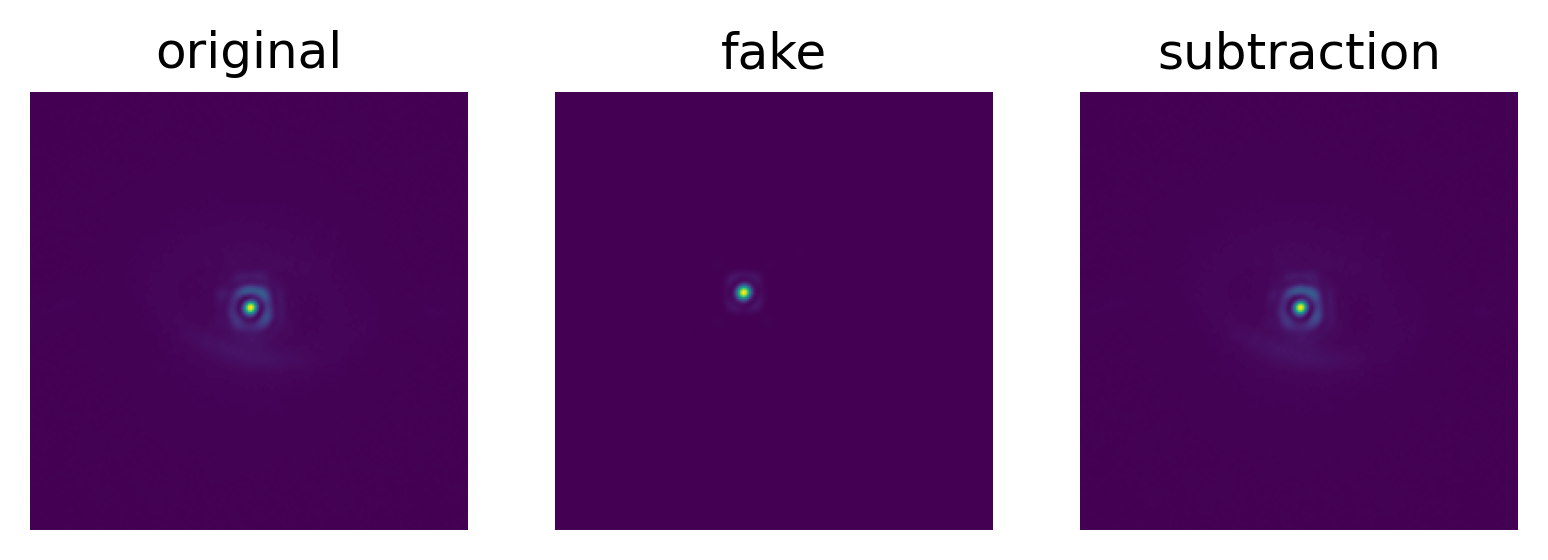

In [148]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(cube[0], origin='lower')
axes[1].imshow(injected[0], origin='lower')
axes[2].imshow(clean_cube[0], origin='lower')

for ax, title in zip(axes, ['original', 'fake', 'subtraction']):
    ax.axis('off')
#     ax.set_xlim(row['optimal_x']-40, row['optimal_x']+40)
#     ax.set_ylim(row['optimal_y']-20, row['optimal_y']+50)
    ax.set_title(title)

## step 2: Draw rings FWHM-diameter apertures

In [313]:
nframes, width, height = cube.shape
max_boundary = width * 0.5
num_rings =  40

regions = get_rings(row['optimal_x'], row['optimal_y'], 
                    fhwm=row['fwhm_mean'],
                    cube=clean_cube, 
                    rot_angles=rot_angles,
                    num_rings=num_rings)

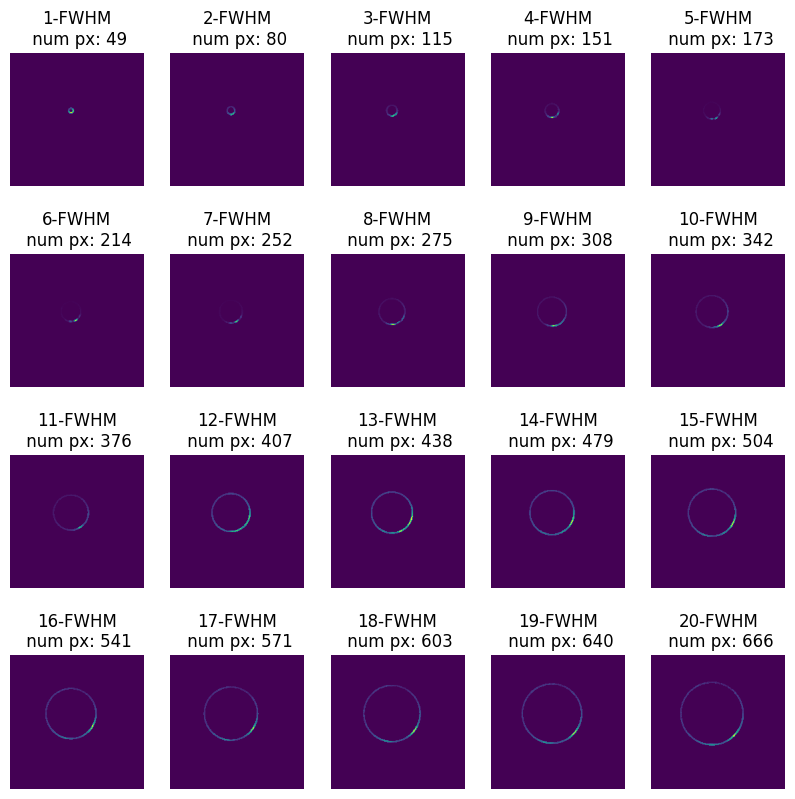

In [314]:
fig, axes = plt.subplots(4, 5, figsize=(10,10))
axes = axes.flatten()
for i in range(1, 21):
    N = np.sum(regions[i-1][0]!=0.)
    axes[i-1].imshow(regions[i-1][0])
    axes[i-1].axis('off')
    axes[i-1].set_title('{}-FWHM\n num px: {}'.format(i, N))

## step 3: Find the fraction of resolution element whose sum exceeds the detection threshold

In [315]:
ap_phot = get_aperture_photometry(cube, row['optimal_x'], row['optimal_y'], 
                               rot_angles=rot_angles,
                               fwhm=row['fwhm_mean'])

In [316]:
contrast = get_contrast(regions, ap_phot, factor=5)

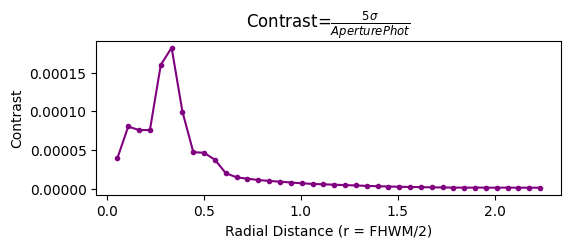

In [318]:
import matplotlib.ticker as ticker
x_range = np.arange(1, 41, 1)
plt.figure(figsize=(6, 2))

plt.plot(x_range*row['fwhm_mean']*0.01225, contrast, marker='.', color='purple')
plt.ylabel(r'Contrast')
plt.xlabel('Radial Distance (r = FHWM/2)')

plt.title(r'Contrast=$\frac{5\sigma}{AperturePhot}$')
plt.show()

## step 4: Estimate the algorithm throughput 

In [291]:
psfs.shape

(2, 63, 63)

In [292]:
%%time
table, injected, model = get_throughput(clean_cube, 
                                        psfs, 
                                        rot_angles, 
                                        flux=1000.,
                                        fwhm=row['fwhm_mean'],
                                        window_size=15)

Branch 1:
	(X,Y)=(97.77, 100.46) at 0.03 arcsec (2.28 pxs from center)
[INFO] Training (x, y) = (97.77 100.46)


2023-08-11 19:09:27.648879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 19:09:27.659953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 19:09:27.700361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

Branch 1:
	(X,Y)=(97.77, 100.46) at 0.03 arcsec (2.28 pxs from center)
CPU times: user 1.95 s, sys: 432 ms, total: 2.39 s
Wall time: 6.38 s


In [301]:
table

,index,x,y,flux,fwhm_mean,optimal_flux,optimal_x,optimal_y
0,0,97.767785,100.462115,1000.0,4.559094,1040.307861,97.772614,100.464409


In [311]:
from core.engine import rotate_cube
tput = residuals/injected
tput = rotate_cube(tput, rot_angles)
mask = np.where(regions!=0., 1., 0.)
valid_region = tput[...,0]*mask[1]

In [307]:
throughput = np.mean(valid_region)

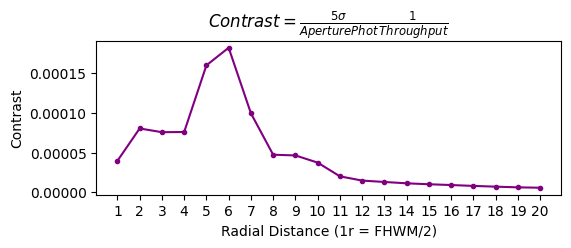

In [309]:
x_range = range(1, 21, 1)
plt.figure(figsize=(6, 2))
plt.plot(x_range, np.array(contrast), marker='.', color='purple')
plt.ylabel(r'Contrast')
plt.xlabel('Radial Distance (1r = FHWM/2)')
plt.xticks(x_range)
plt.title(r'$Contrast=\frac{5\sigma}{AperturePhot} \frac{1}{Throughput}$')
plt.show()